# Lab 9: Twitter data analysis  

In this lab, we will learn how to read JSON files and how to perform exploratory analysis of twitter data. As an extra credit, you will learn how to use API to download tweets on the topic of your choice.

Let us start by importing the needed packages.

In [1]:
import json
import random
import time
import calendar
import codecs
import datetime
import sys
import gzip
import string
import glob
import os
import numpy as np
import dateutil.parser

## Module 0: Reading Tweets

Tweets are saved in the form of a JSON file. Open `onetweet` file in a text editor and study how it looks. This file contains information from a single tweet. The file is written in the JSON format, which is easy for a computer to read and parse. 

**Question 1**. Google `JSON` and try to learn about this particular data format. Explain in one or two paragraphs what you learned.

Let us read `onetweet` JSON file. We will create an object and print it.

**Answer 1:** <br>
JSON, aka JavaScript Object Notation, is a type of data-interchange text format which makes things easier for human readability and computer parsing of the information. The information is stored as objects and within each object it is further stored as properties. The properties are stored in string syntax with the values being numerical or string values as well. These values can be called directly using the dot(.) format. Ex: objectname.property returns value stored in that property
<br>
If one would like to store more than one set of values 

In [2]:
from pprint import pprint
tweet = json.load(open('onetweet', 'rb'))
pprint (tweet)

{'_id': '264230205529411585',
 'contributors': None,
 'coordinates': {'coordinates': [-73.95639896, 40.71411847], 'type': 'Point'},
 'created_at': '2012-11-02T04:59:24',
 'disaster': '2012_sandy_hurricane_en',
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [{'display_url': 'instagr.am/p/Rg70o6xlkY/',
                        'expanded_url': 'http://instagr.am/p/Rg70o6xlkY/',
                        'indices': [33, 53],
                        'url': 'http://t.co/G0LdsQAz'}],
              'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'geo': {'coordinates': [40.71411847, -73.95639896], 'type': 'Point'},
 'id': '264230205529411585',
 'id_str': '264230205529411585',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': {'attributes': {},
           'bounding_box': {'coordinat

As we can see, each tweet is stored in a dictionary. Although there are more than 20 different keys in the dictionary, we introduce the most important fields which will be used in the rest of this lab.
<ul>
<li>'_id': shows the unique id of this tweet.</li>

<li>'coordinates': shows the location from which the tweet was posted. The field might be null if the tweet contains no location data, or it could contain bounding box information, place information, or GPS coordinates in the form of (longitude, latitude). </li>

<li>'created_at': shows the time the tweet has been created.</li>

<li>'text': shows the text of the tweet.</li>

<li>'user': contains multiple dictionaries describing the user, including the name of this user, the number of followers, the number of friends...</li>
</ul>

**Question 2**. Explain 3 more keys that you find interesting

**Answer 2:**
1. 'entities': provides information regarding the metadata of the tweet, such as hashtags added, user mentions, and any url links added.
2. 'retweeted_count': returns the number of times this tweet has been retweeted (which is 0 in this case T.T)
3. 'source': refers to how the tweet was posted. In our case the photo was originally from Instagram.

In the following code we will load around 4,000 tweets sent from New York City region during Sandy Hurricane from a JSON file `smallNYC.json`. As part of this process, we will extract each tweet's post time and create a time series of the number of tweets in each hour during the event.

In [3]:
filePath='smallNYC.json'
localTweetList = []
globalTweetCounter = 0
frequencyMap = {}
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    
    # Try to extract the time of the tweet
    currentTime=dateutil.parser.parse(tweetObj['created_at'])
    currentTime = currentTime.replace(second=0)
    currentTime = currentTime.replace(minute=0)

    #print currentTime
    # Increment tweet count
    globalTweetCounter += 1
    
    # If our frequency map already has this time, use it, otherwise add
    if ( currentTime in frequencyMap.keys() ):
        timeMap = frequencyMap[currentTime]
        timeMap["count"] += 1
        timeMap["list"].append(tweetObj)
    else:
        frequencyMap[currentTime] = {"count":1, "list":[tweetObj]}

# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

#timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
timeIntervalStep = datetime.timedelta(hours=1)
while ( thisTime <= lastTime ):
    if ( thisTime not in frequencyMap.keys() ):
        frequencyMap[thisTime] = {"count":0, "list":[]}
        
    thisTime = thisTime + timeIntervalStep

print ("Processed Tweet Count:", globalTweetCounter)

Processed Tweet Count: 4295


## Module 1: Simple Frequency Analysis

In this section, we will cover a few simple analysis techniques for EDA of the available twitter datay.

- Twitter Timeline
- Top Twitter Users
- Twitter API
- Posting Frequency Distribution
- Popular Hashtags
- Simple Event Detection
- Language Distributions

### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per hour.

Time Frame: 2012-10-22 05:00:00 2012-11-02 04:00:00


<Figure size 432x288 with 0 Axes>

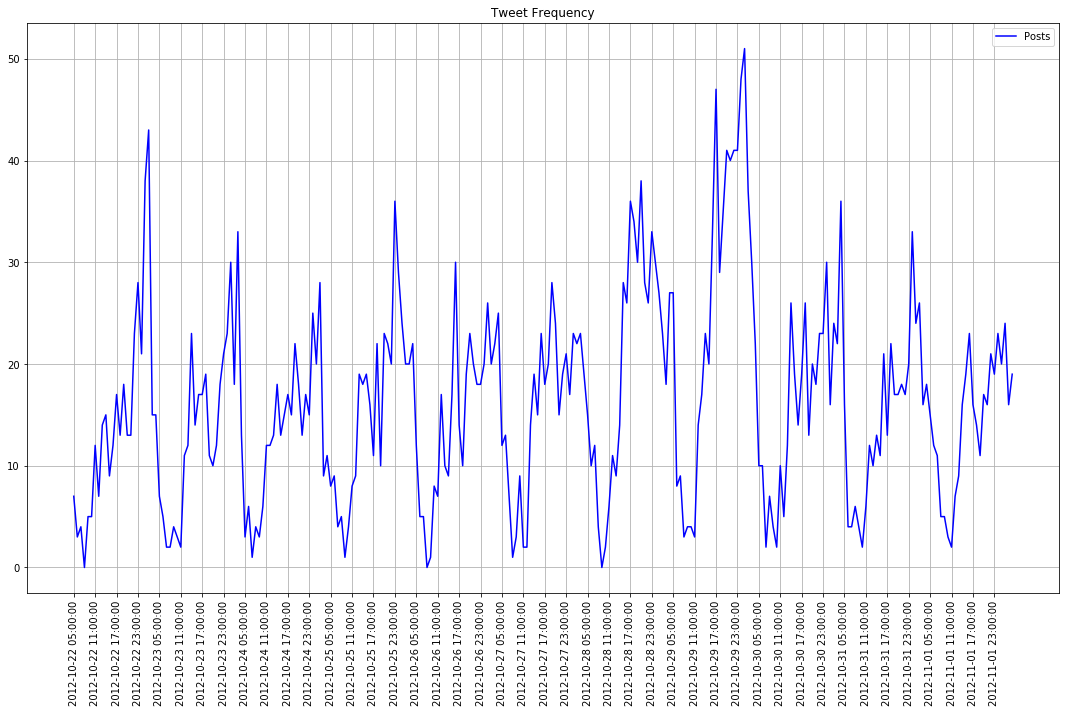

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]

# We'll have ticks every thirty minutes (much more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 6)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(frequencyMap)), [x if x > 0 else 0 for x in postFreqList], color="blue", label="Posts")
ax.grid(b=True, which=u'major')
ax.legend()
plt.figure()

**Question 3**. When is the tweeting activity the largest? Find a wikipedia article about the Sandy Hurricane to understand the timeline of events surrounding it. Discuss if you see a correlation with the tweet frequencies. Select some tweets from different time points and see if the messages are correlated with the events on the ground.

In [5]:
#for i in frequencyMap[datetime.datetime(2012, 10, 23, 2, 0)]['list']:
#    print(i['text'])

#print()
#for i in frequencyMap[datetime.datetime(2012, 10, 25, 23, 0)]['list']:
#    print(i['text'])

for i in frequencyMap[datetime.datetime(2012, 10, 30, 1, 0)]['list']:
    print(i['text'])

@bpacris power and Internet. Text if you need to come this way.
@aviggz so does mine she keeps saying its the end of the world
No candles? Nbd. I guess it's time to crack some glow sticks and play edm Muahahahhaha
Carro sendo resgatado no alagamento. #Sandy http://t.co/UgW1it4n
Rain then wind = free car wash. Thanks Sandy!
@crisstyram @reymysterio Hell Yeah! As soon as Sandy GTFO then I go to @GameStop and pick up my preordered #WWE13
I'm at Frankenstorm Apocalypse - Hurricane Sandy w/ @beaniev [pic]: http://t.co/NMkrbayF
@DeAngelo_Gina You're welcome!
My house just violently shook
Ok, it's official. The power went out. Great.
I'm at Frankenstorm Apocalypse - Hurricane Sandy (New York, NY) w/ 2947 others http://t.co/JttkVoRJ
Thats not fair sam has power and i dont .-.
Lmao dead! RT"@LuztotheMary: I'm gonna go to school on Wednesday looking like a cow, and I'm not talking Halloween costume."
I wanna go outside for some reason lol let me just chill lol
I'm locked up, they won't let me ou

**Answer 3:** <br>
Tweeting activity is largest between the times of October 29th, 2012, 11:00PM and October 30, 2012, 5:00AM. The hurricane hit land at Atlantic City, NJ, near NYC around Oct. 28th and 29th of that year, hence why there was a spike in the amount of tweets. Probably either about the storm itself, finding shelther, or people reporting to families that they are safe. On the same day of Oct. 28th, the senator of NY also announced a state of emergency for the impending storm along with President Obama later that same day. It's understandable for spikes in tweeting on Oct. 22nd into 23rd as well since that is when the beginning signs of Sandy developing as a tropical wave began before updating to a Tropical Storm several hours later. Then on Oct. 24th it was reported as a legitimate hurricane.
There was another slight spike on Oct. 25th when Sandy hit Cuba as a category 3 storm before lulling down to a category 1. From the rundown of events, it does seem there is a correlation in the tweet frequencies.
<br>
However, looking at the text messages of each tweet at the times prior to the moment Sandy hit NYC, they were all about personal events or miscellaneous messages. It wasn't until night time of October 29th/30th when the hurricane caused power outages and road closures throughout the city that people began tweeting about it. Also another note worth mentioning, in the previous spikes on Oct. 23rd and 25th, they were still classified under the key `'disaster'` even though they weren't exactly related to the event. Therefore, the misconception that these tweets could be related to Hurricane Sandy although their texts reveal otherwise.

### Top Twitter Users

The following piece of code reveals the users that produced the most tweets. 

In [6]:
# Create maps for holding counts and tweets for each user
globalUserCounter = {}
globalUserMap = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if ( user not in globalUserCounter ):
            globalUserCounter[user] = 1
            globalUserMap[user] = [tweet]
        else:
            globalUserCounter[user] += 1
            globalUserMap[user].append(tweet)

print ("Unique Users:", len(globalUserCounter.keys()))

Unique Users: 3042


In [7]:
sortedUsers = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)
print ("Top Ten Most Prolific Users:")
for u in sortedUsers[:10]:
    print (u, globalUserCounter[u], "\n\t", "Random Tweet:", globalUserMap[u][0]["text"], "\n----------")

Top Ten Most Prolific Users:
Young_Boss718 37 
	 Random Tweet: That random text  I had got be for LMFAO shit was funny 
----------
frankieciv608 15 
	 Random Tweet: “@JohnKincade Dear Donald Trump,
Americans &amp; Republicans chose to not involve you in this election between Prez &amp; Romney.
Please go away.” 
----------
Cocky_Johnny 15 
	 Random Tweet: @_tinaDeex3 LMAO #Dead 
----------
labroides 14 
	 Random Tweet: @SharkDevocean best of luck. That's awesome 
----------
ReelTalker 12 
	 Random Tweet: @FilmFatale_NYC also, in other news, i totally thought it was idris who tweeted me. Saw the pic and got  excited :-) 
----------
Amooniac 11 
	 Random Tweet: Je Hyper nul en Francais mais je sais qu'on ne dit pas le PLUS piire ! SEIGNEUR aidez moi a comprendre ce qui n'a pas marché ak @mhathe911 
----------
kcastrox3 11 
	 Random Tweet: Cuz this love is a sure thing. 
----------
carolsommers727 11 
	 Random Tweet: @coreymach lookin spiffy 👌 
----------
_LizmaryA 11 
	 Random Tweet: Hey 

**Question 4**. Find and print the top 10 users with the most friends. Find and print the top 10 users with the most followers. 

In [8]:
## Answer 4
# create a global counter to store each user's friends_count and each user's followers_count
globalFriendCount = {}
globalFollowerCount = {}

for user in globalUserMap.keys():   # iterate through each username within the keys
    globalFriendCount[user] = 0
    globalFollowerCount[user] = 0
    tweetlist = globalUserMap[user]
    
    # For loop through all tweets to find whichever tweet has the record of most friends and followers for this user.
    # I know it's not necessarily the "up-to-date" recorded number of followers hence not exactly accurate but
    # my excuse is I've stopped caring about this trivial stuff and that's too complicated... so it works it works! 
    for tweet in tweetlist:
        if(tweet['user']['friends_count']>globalFriendCount[user]):
            globalFriendCount[user] = tweet['user']['friends_count']
        if(tweet['user']['followers_count']>globalFollowerCount[user]):
            globalFollowerCount[user] = tweet['user']['followers_count']

# Sorting the friendcount dictionary and then printing out the top ten
sortFriends = sorted(globalFriendCount, key=globalFriendCount.get, reverse=True)
print ("Top Ten Users with Most Friends:")
for u in sortFriends[:10]:
    print (u, globalFriendCount[u], "\n----------")

print('\n')

# Sorting the followerscount dictionary
sortFollowers = sorted(globalFollowerCount, key=globalFollowerCount.get, reverse=True)
print ("Top Ten Most Followed Users:")
for u in sortFollowers[:10]:
    print (u, globalFollowerCount[u], "\n----------")

Top Ten Users with Most Friends:
mstupenengo 49501 
----------
GinsburgJobs 49441 
----------
WeAreJocelyn 37969 
----------
MrThugZilla2K15 33902 
----------
davesurber 29221 
----------
55_althani 26416 
----------
EddieJMontanez 21663 
----------
andrewcotto 17312 
----------
MargaretMolloy 16958 
----------
tupaclivesss 11334 
----------


Top Ten Most Followed Users:
mstupenengo 1162644 
----------
iJokes_ 185923 
----------
felixsalmon 164709 
----------
EmersonOverton 155045 
----------
umakhouny 126453 
----------
AgramyQ8 112323 
----------
55_althani 94191 
----------
QueensMuseum 80871 
----------
JosephWakile 73103 
----------
Majovargas_ 67256 
----------


### Distribution of Postings

It appears a few users were posting to Twitter a lot. But how often did most Twitter users tweet during this time? We can build a histogram to see this distribution.


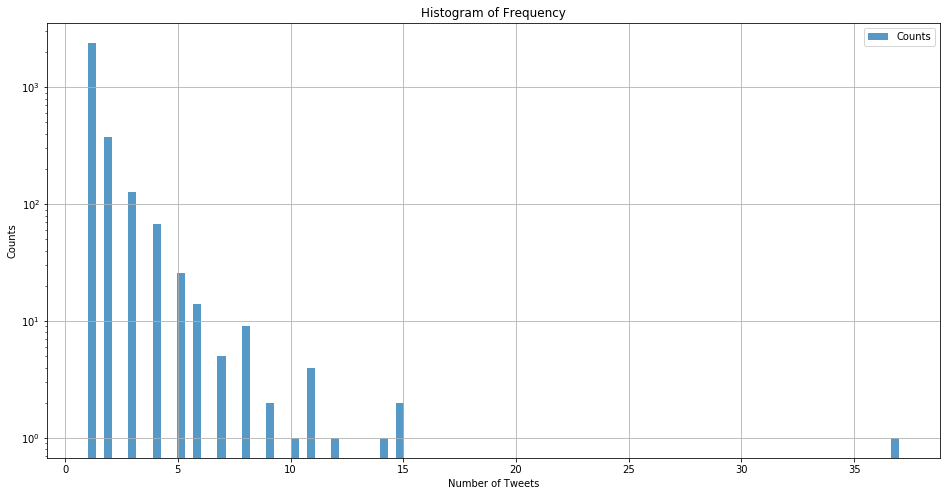

In [9]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.hist(
    [globalUserCounter[x] for x in globalUserCounter], 
    bins=100, 
    density=0, 
    alpha=0.75,
    label="Counts",
    log=True)

plt.xlabel('Number of Tweets')
plt.ylabel('Counts')
plt.title("Histogram of Frequency")
plt.grid(True)
plt.legend()

plt.show()

**Question 5**. Study 3 users with the most posts. What were they tweeting about?

In [10]:
topThree = sortedUsers[:3]
for user in topThree:
    tweetlist = globalUserMap[user]
    print(user)
    for tweet in tweetlist:
        print(tweet['text'])
    print('\n---------------------')

#   They were tweeting about dumb stuff, literally! These are either teens or people in their early twenties posting
# about random things in their lives (cursing, sex, and nudes). Pretty much anything not related to Hurricane Sandy.
# Occasionally the second most prolific user posted about politics (2012 election of Obama vs Romney).

Young_Boss718
That random text  I had got be for LMFAO shit was funny
@MeerGotGame don't try and find shit lol
U inbox her on fb or text her
That wax museum is a fool in New York shit be real af
I kinda just felt when she just said idgaf lol
We be on the loud shit
Y'all be smoking that low volume
@BossBitchShxt chill out Monae you know I fucks with fab lol
I got my list tho 🙈🙉🙊
@The_Good_Fella9 it's ok
@NOFcks_Givn gave that head to ?
PART2
@The_Good_Fella9 word she's cool af
i wonder who had crush on me on twitter 😜😝😛😵
White girls don't have butts LMFAO
@BricksFromPluto lol
@SugarCocaine_ well I heard mad down south ppl say it that's why I ask
Getting alil sleepy
Moms gone for the whole night shit just about to smoke &amp; kick it with da homies
@LiyahhDoeee I know that's not you in them heels and skirt
@MikeyGotBudd I fucks with the mishka shirt fam
@Loud_Everyday 💯 already know
@She_Suckedd nigga shut up 😒
The pic jaida just posted -_-
No more talking, let’s be about it
Sexcapade,
B

### Average Number of Posts

In [11]:
avgPostCount = np.mean([globalUserCounter[x] for x in globalUserCounter])
print("Average Number of Posts:", avgPostCount)

Average Number of Posts: 1.4119000657462195


### Popular Hashtags

Hashtags give us a quick way to view the conversation and see what people are discussing. Getting the most popular hashtags is just as easy as getting the most prolific users.


In [12]:
# A map for hashtag counts
hashtagCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
            else:
                hashtagCounter[hashtagString] += 1

print ("Unique Hashtags:", len(hashtagCounter.keys()))
sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
print ("Top Twenty Hashtags:")
for ht in sortedHashtags[:20]:
    print ("\t", "#" + ht, hashtagCounter[ht])

Unique Hashtags: 997
Top Twenty Hashtags:
	 #sandy 108
	 #nyc 47
	 #hurricanesandy 26
	 #newyork 12
	 #brooklyn 9
	 #halloween 8
	 #instagood 8
	 #photooftheday 8
	 #frankenstorm 8
	 #hurricane 8
	 #centralpark 7
	 #debates 6
	 #instamood 6
	 #satstudytime 6
	 #igers 5
	 #picoftheday 5
	 #instagramhub 5
	 #instadaily 5
	 #oomf 5
	 #newyorkcity 5


### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.


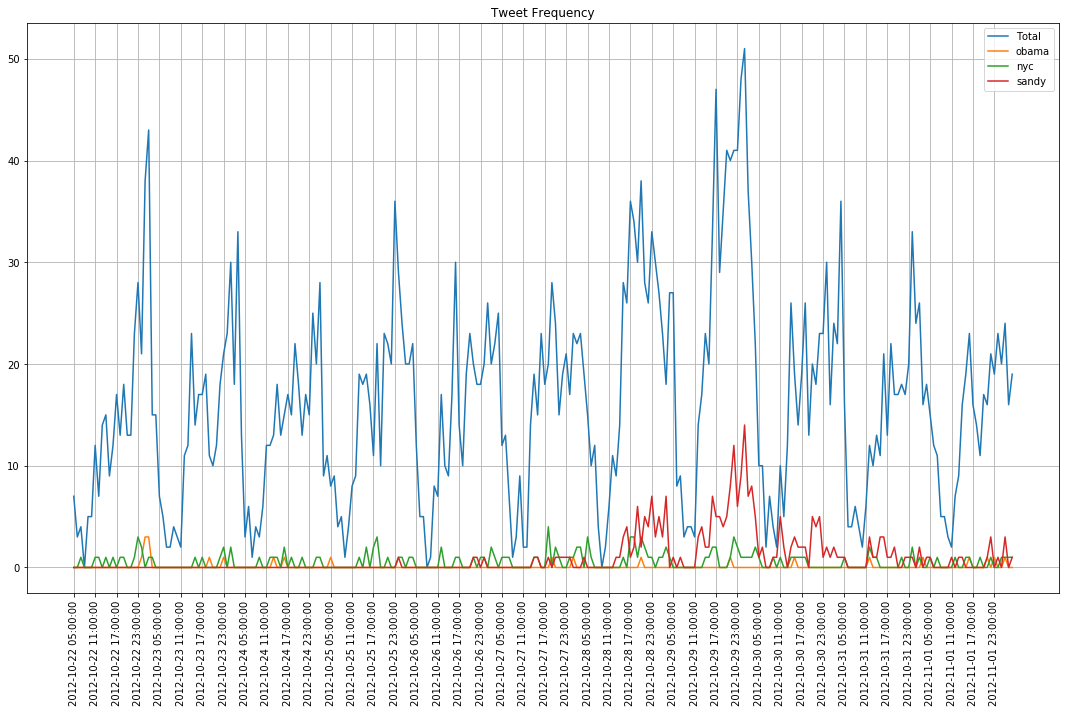

In [13]:
# What keywords are we interested in?
targetKeywords = ["obama", "nyc"]
# targetKeywords.append("lowery")
# targetKeywords.append("reilly")
targetKeywords.append("sandy")

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

ax.plot(range(len(frequencyMap)), totalCount, label="Total")
# label represents adding the equivalent string to the legend

for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Question 6**. Study some example codes with 2 different hashtags. Explain how are those messages different. 

**Question 7**. Which among the top 20 hashtags are related to Sandy. What are the most popular non-Sandy hashtags? 

**Question 8**. Among the top 20 hashtags, try to find which of them were particularly popular before Sandy, during Sandy, and those whose popularity did not change much. Try to apply k-means clustering on the time series of hashtags to try to find similar groups of hashtags. Discuss your findings.

**Answer 6:** <br>
So funniest thing is that I wanted to compare what tweets two different cities are posting about because `Hoboken`, I know, is a city in NJ just right next to `NYC`. Meanwhile I also wanted to compare what differences does it make hashtagging between NYC and the full name `New York City`. Unsurprisingly both cities started tweeting a lot about Hurricane Sandy nearing the end of each list value within my dictionary as tweet were fetched based on the chronological order of the time series. The only difference is that more people enjoy using the shortened hashtag of nyc. The surprising discovery, though, is that the way I scraped the tweets ended up with more tweet counts in each list of tweets stored as dictionary values compared to the counts found in hashtagCounter. I'm not sure what the error is that occurred in the hashtagCounter as I've double checked my own hashtagDict and verified that at least the counts of `hoboken` and `new york city` do seem higher than hashtagCounter. 

In [16]:
print(sortedHashtags[20:40])
for hashtag in sortedHashtags[20:40]:
    print('\t', '#'+hashtag, hashtagCounter[hashtag])

['jets', 'studyingforthesat', '100thingsaboutme', 'smackboi', 'fall', 'jobs', 'debate', 'omg', 'love', 'bored', 'hoboken', 'strataconf', 'romney', 'raw', 'debate2012', 'obama2012', 'sexy', 'foodporn', 'red', 'jj']
	 #jets 5
	 #studyingforthesat 5
	 #100thingsaboutme 5
	 #smackboi 5
	 #fall 4
	 #jobs 4
	 #debate 4
	 #omg 4
	 #love 4
	 #bored 4
	 #hoboken 4
	 #strataconf 3
	 #romney 3
	 #raw 3
	 #debate2012 3
	 #obama2012 3
	 #sexy 3
	 #foodporn 3
	 #red 3
	 #jj 3


In [113]:
hashtagDict = {"nyc": [], "newyorkcity": [], "hoboken": []}

# First loop through the hashtag dictionary
for hashtag in hashtagDict.keys():
    # Repeat loop through the frequency map to find hashtag list of 
    for t in sortedTimes:
        timeObj = frequencyMap[t]
        for tweet in timeObj['list']:
            hashtagList = tweet["entities"]["hashtags"]
            for hashtagObj in hashtagList:
                # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
                hashtagString = hashtagObj["text"].lower()
                if (hashtagString in hashtagDict):
                    hashtagDict[hashtagString].append(tweet['text'])

for key in hashtagDict.keys():
    print('#'+key, ':', len(hashtagDict[key]))
pprint(hashtagDict)

#nyc : 141
#newyorkcity : 15
#hoboken : 12
{'hoboken': ['Worked til 11pm now headed to the Shannon #Hoboken to forget '
             'about it with @DonnaZitelli',
             "Coastal areas bear brunt of Sandy's damaging wrath -Sumter Item "
             'http://t.co/Z0A9D1K2 #Hoboken #NJ',
             'Hey #Sandy, Welcome to #Hoboken. "nikocoutroulis\'s photo '
             'http://t.co/6PwN0qTM"',
             '@Kathy_hospiceRN Just read that routes from the north are '
             'opening. You might be able to find a way into #hoboken tomorrow.',
             'Worked til 11pm now headed to the Shannon #Hoboken to forget '
             'about it with @DonnaZitelli',
             "Coastal areas bear brunt of Sandy's damaging wrath -Sumter Item "
             'http://t.co/Z0A9D1K2 #Hoboken #NJ',
             'Hey #Sandy, Welcome to #Hoboken. "nikocoutroulis\'s photo '
             'http://t.co/6PwN0qTM"',
             '@Kathy_hospiceRN Just read that routes from the north are '
  

**Answer 7:** <br>
Among the top 20 hashtags related to Sandy:
- #sandy
- #hurricanesandy
- #frankenstorm
- #hurricane
<br>

The most popular non-Sandy hashtags are all those other hashtags within the top 20 which aren't within the list above. I chose to not add #nyc, #newyork, #brooklyn, #centralpark, and #newyorkcity into the mix of hashtags because there's a chance some of them aren't related to the hurricane. I would have to look at every hashtag occurence's accompanying text to confirm if there is any mention of hurricane Sandy.

In [ ]:
## Answer 8


### Language Distribution

The following code gives an insight into the languages used for the tweets in your data.


In [27]:
# A map for counting each language
languageCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        lang = tweet["lang"]
        
        if ( lang not in languageCounter ):
            languageCounter[lang] = 1
        else:
            languageCounter[lang] += 1
            
languages = sorted(languageCounter.keys(), key=languageCounter.get, reverse=True)

for l in languages:
    print (l, languageCounter[l])

en 3688
es 192
und 162
tl 29
fr 27
pt 24
ar 20
ht 20
tr 20
ru 18
it 16
in 16
de 6
ja 6
nl 6
sv 5
ko 4
fi 4
pl 4
lv 3
ro 3
hi 3
is 2
da 2
cs 2
cy 2
vi 2
et 2
sl 2
zh 1
hu 1
fa 1
lt 1
eu 1


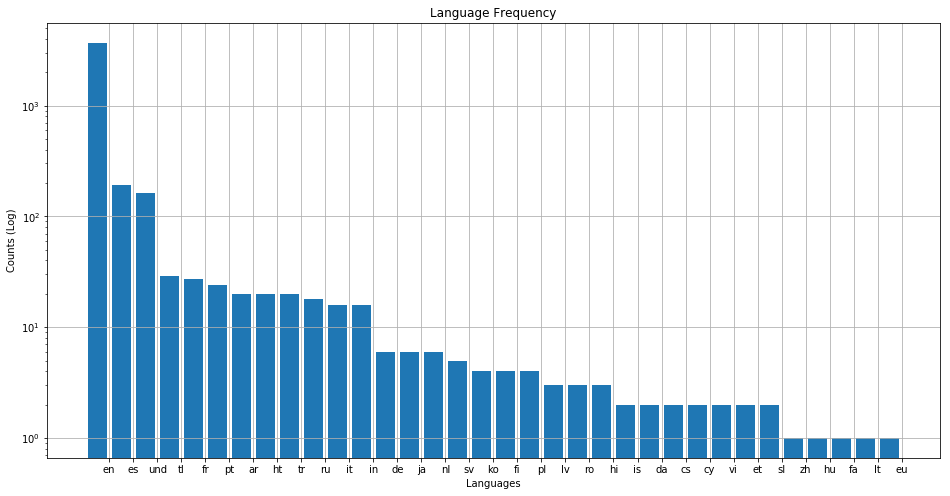

In [43]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.bar(
    np.arange(len(languages)),
    [languageCounter[x] for x in languages],
    log=True)

plt.xticks(np.arange(len(languages)) + 0.5, languages)
plt.xlabel('Languages')
plt.ylabel('Counts (Log)')
plt.title("Language Frequency")
plt.grid(True)

plt.show()

**Quesiton 9**. Now that you have experience in extracting different types of information from twitter data, perform your own EDA. Produce a 1-page report providing some interesting insights about the Sandy twitter data.

## Module 2: Classification

In this part of the lab, we will work on a binary classificaiton problem. In particular, we would like to see how easy it is to discriminate between tweets with hashtag #sandy and the rest of them. To do it, we will first create labels: positive tweets will be those with hashtag #sandy and negative those without the hashtag. Then, we we will create a bag-of-words vector out of each tweet, but we will exclude word "#sandy". To produce the bag-of-words representation we will use the `CountVectorizer` functionality 

In [27]:
import pandas as pd
import numpy as np
import codecs, json

"""
Step 1. Create sentences and labels from json file. 
"""
filePath='smallNYC.json'
sents = []
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    sents.append(tweetObj['text'])
    
"""
Step 2.1. Get label. If sent contains '#sandy', label=1; otherwise, label=0
"""
labels = np.array(['#sandy' in sent.split() for sent in sents], dtype='int')
print(pd.Series(labels).value_counts())
"""
Step 2.2. Represent the data into Bag-of-words features, i.e, each sentence is a 
            vector of word counts. 
          a). Only select words with frequency >= 5
          b). Remove label words '#sandy'
"""

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words = ['#sandy'])
features = vectorizer.fit_transform(sents)


print('#sandy' in vectorizer.get_feature_names())
print(features.toarray())
print(vectorizer.get_feature_names())

0    4234
1      61
dtype: int64
<class 'scipy.sparse.csr.csr_matrix'>
False
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['00', '10', '100thingsaboutme', '12', '13', '14', '15', '16', '18', '20', '2012', '21', '24', '26', '28', '2nd', '30', '40', '50', '6th', 'able', 'about', 'actually', 'ads', 'adventure', 'af', 'after', 'afternoon', 'again', 'against', 'ago', 'ain', 'air', 'airport', 'al', 'album', 'alert', 'alive', 'all', 'almost', 'already', 'also', 'always', 'am', 'amazing', 'america', 'american', 'amp', 'an', 'and', 'another', 'any', 'anyone', 'anything', 'anyway', 'apartment', 'apocalypse', 'app', 'apple', 'appreciate', 'aqui', 'are', 'area', 'aren', 'around', 'art', 'as', 'ask', 'asked', 'asleep', 'ass', 'astoria', 'at', 'ave', 'avenue', 'away', 'awesome', 'awkward', 'aww', 'awww', 'babe', 'baby', 'back', 'bacon', 'bad', 'ballroom', 'bar', 'barclays', 'battery', 'be', 'beach', 'beat', 'beautiful', 'beca

**Quesiton 10**. Given the data set of labeled tweets, you have to train a classification model and check the accuracy. Remember to first split the data into training and test. You should explore kNN classification, decision tree classification, Random Forest classification.

**Question 11**. Train the so-called *Logistic regression classifier* and check its accuracy. Compare with the results from *Question 10*. The following lines of code will be useful to do it.

In [46]:
"""
Step 3. Divide data into train and test 
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42) 
import time
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression()
start_time = time.time()
clf.fit(X_train, y_train)
print('Time for %s fitting: %.3f' % ('LogisticRegression', time.time() - start_time))
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc))

Time for LogisticRegression fitting: 0.021
Test Perf ACC: 0.988, AUC: 0.986


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [100]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

**Answer 10:** <br>
Believe I've trained the 3 classification models of kNN, Decision Tree, and Random Forest. I've just left them simply at their default values with the exceptions of kNN I chose to use `k=10` and the random forest I tested using parameters that worked well in the previous lab. Funniest thing is that in the previous lab we had to train another classifier of our own choice and I luckily chose Random Forest. So I found the parameters in the commented out RFC constructor provided the best accuracy with the previous data. With this data, all three classifiers did an excellent job averaging at least 98% each.

In [101]:
## kNN
k = 10
predictor = KNeighborsClassifier(n_neighbors = k)
predictor.fit(X_train, y_train);
print(predictor)

yhat_train = predictor.predict(X_train)
print('kNN Training data accuracy:', accuracy_score(y_train, yhat_train))

yhat = predictor.predict(X_test)
print('kNN Test data accuracy:', accuracy_score(y_test, yhat))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')
kNN Training data accuracy: 0.9843587069864442
kNN Test data accuracy: 0.9880112834978844


In [102]:
# Decision Trees
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(clf)

yhat_train = clf.predict(X_train)
print('DT Training data accuracy:', accuracy_score(y_train, yhat_train))

yhat = clf.predict(X_test)
print('DT Test data accuracy:', accuracy_score(y_test, yhat))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
DT Training data accuracy: 1.0
DT Test data accuracy: 0.9858956276445698


In [103]:
# Random Forest
#forest = RandomForestClassifier(50, 'entropy', 4, 5)
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

yhat_train = forest.predict(X_train)
print('RF Training data acccuracy:', accuracy_score(y_train,yhat_train))

yhat = forest.predict(X_test)
print('RF Testing data acccuracy:', accuracy_score(y_test,yhat))

RF Training data acccuracy: 0.9975669099756691
RF Testing data acccuracy: 0.9887165021156559


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Answer 11:** <br>
The Logistic Regression classifier used below results with an accuracy that is comparable to the above three classifiers. On avaerage it does the same as the Random Forest and kNN algorithm in terms of predicting test data with accuracy as high as 98.8%. 

In [104]:
reg = LogisticRegression()
reg.fit(X_train, y_train)

yhat_train = reg.predict(X_train)
print('LR Training data accuracy:', accuracy_score(y_train, yhat_train))

y_pred = reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_prob = reg.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc))

LR Training data accuracy: 0.9961765728189086
Test Perf ACC: 0.988, AUC: 0.986


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Module 3. Extra Credit: Using API to Download Tweets (50 extra points)

To run the following code you will need to install the `tweepy` package.

* Create a twitter account if you do not already have one
* Go to https://apps.twitter.com/ and log in with your twitter credentials.
* Click 'Create New App'
* Fill out the Name, Description, Website fields and agree the terms. Put in any website you want if you don't have one you want to use.
* On the next page, click the 'Keys and Access Tokens' tab along the top, then scroll all the way down until you see the section 'Your Access Token
* Click the button 'Create My Access Token'.
* You will now copy four values below. These values are your 'Consumer Key (API Key)', your 'Consumer Secret (API Secret)', your 'Access token' and your 'Access token secret'. All four should now be visible on the 'Keys and Access Tokens' page. Set the variables corresponding to the API key, API secret, access token, and access secret. You will see code like the below:


In [ ]:

from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json, sys
import codecs



ckey = "<Enter api key>"
csecret = "<Enter api secret>"
atoken = "<Enter your access token key here>"
asecret = "<Enter your access token secret here>"

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

output = codecs.open('twitter_data.json', 'wb', encoding='utf-8')
line_num = 0
class CustomStreamListener(StreamListener):
    def on_status(self, status):
        print status.text

    def on_data(self, data):
        json_data = json.loads(data)
        output.write(str(json_data))
        output.write("\n")

    def on_error(self, status_code):
        print >> sys.stderr, 'Encountered error with status code:', status_code
        return True # Don't kill the stream

    def on_timeout(self):
        print >> sys.stderr, 'Timeout...'
        return True # Don't kill the stream




The following line of code allows you to download the current stream of codes that contain word *basketball*.

In [ ]:
twitterStream = Stream(auth, CustomStreamListener())
twitterStream.filter(track=['basketball'])

You can stop downloading by terminating the process (the stop button in Jupiter menu)

Now you can also filter Tweets by locations by setting the parameters in filter.
By setting the filter(locations = [-75.280291,39.867005,-74.955831,40.137959]), you will
get all tweets from Philadelphia. To get bounding box for other areas, the klokantech's tool can
be used. 
To learn more about Twitter Stream API parameters, please go to: 
    https://dev.twitter.com/streaming/overview/request-parameters 
    
** Extra point Question**. Pick you favorite geographical region, keyword, or a hashtag and download at least 1,000 tweets. Perform any kind of exploratory or predictive data analysis that you find interesting and produce a 2-page report summarizing what you did and why and explaining what kind of results nd insights you obtained.

